In [1]:
# Add the parent directory to the system path 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
# importing modules from scripts 
from scripts.dl_modelling import *
from scripts.logger import setup_logger

In [4]:
# 1. Load and isolate the Rossmann Store Sales dataset into time series data
df_train = pd.read_csv('../data/clean/train.csv')  # Replace with your actual data file

C:\Users\25191\AppData\Local\Temp\ipykernel_15140\2790484199.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../data/clean/train.csv')  # Replace with your actual data file


In [5]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
data = df_train[['Date', 'Store', 'Sales']]

# Filter for a specific store (e.g., Store 1)
store_data = data[data['Store'] == 1]
store_data.set_index('Date', inplace=True)
store_data = store_data.resample('D').sum()

### 2. Check whether your time Series Data is Stationary

In [6]:
# Check stationarity for a specific store
# Perform the ADF test

check_stationarity(store_data['Sales'])

ADF Statistic: -4.3681043682
p-value: 0.0003378835
Critical Values:
	1%: -3.4374778690
	5%: -2.8646866842
	10%: -2.5684454927
The time series is stationary


In [7]:
# Difference the series (store_data is a Series, no need to reference 'Sales')
adf_result = adfuller(store_data['Sales'])
if adf_result[1] >= 0.05:
    store_data['Sales'] = store_data['Sales'].diff().dropna()

### 4. Check for autocorrelation and partial autocorrelation of your data

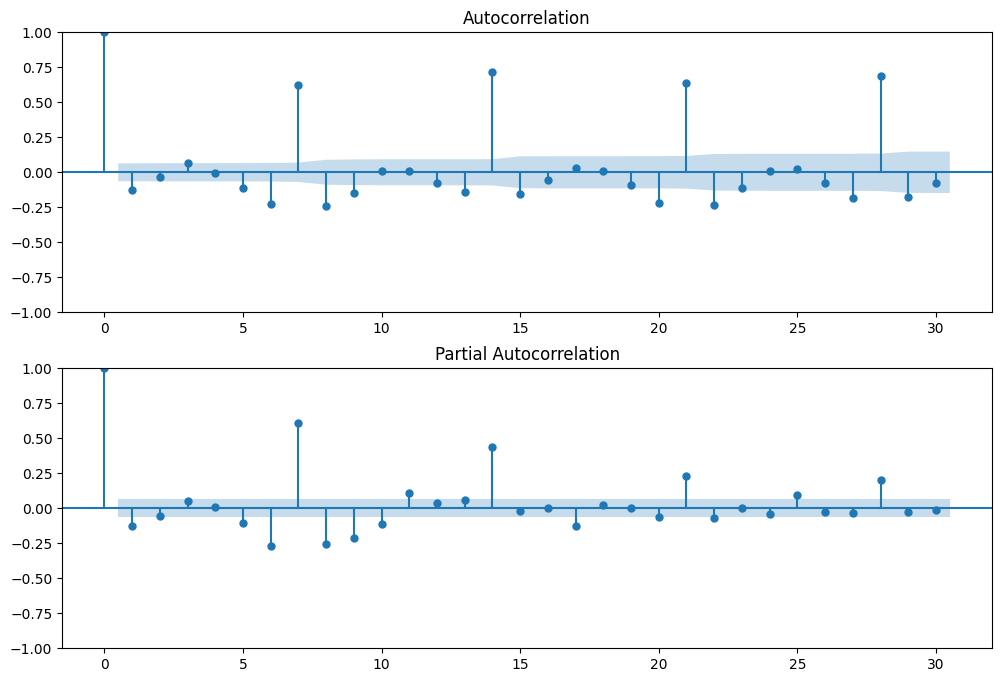

In [8]:
# Autocorrelation and Partial Autocorrelation plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(store_data['Sales'].dropna(), lags=30, ax=ax[0])
plot_pacf(store_data['Sales'].dropna(), lags=30, ax=ax[1])
plt.show()

### 5. Transform the time series data into supervised learning data

In [9]:
# Define time steps
n_step = 30   # number of steps to use for prediction (30 days)
data_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(store_data['Sales'].values.reshape(-1, 1))
X, y = create_supervised_data(data_scaled, n_step)

# Reshape input to be [samples, n_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

### 6. Scale your data in the (-1, 1) range

In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(store_data['Sales'].values.reshape(-1, 1))

# Create dataset for LSTM
X, y = create_supervised_data(data_scaled, n_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

### 7. Build an LSTM Regression model to predict the next sale

In [11]:
# Build and train the LSTM model
model = build_lstm_model(n_step)

In [12]:
### Train the model
history = train_lstm_model(model, X, y)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.1827 - val_loss: 0.1576
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.1939 - val_loss: 0.1635
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1800 - val_loss: 0.1551
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1881 - val_loss: 0.1533
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1677 - val_loss: 0.1532
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1877 - val_loss: 0.1626
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1679 - val_loss: 0.1515
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1874 - val_loss: 0.1538
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1840 - val_loss: 0.1517
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1894 - val_loss: 0.1491
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1932 - val_loss: 0.1509
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0

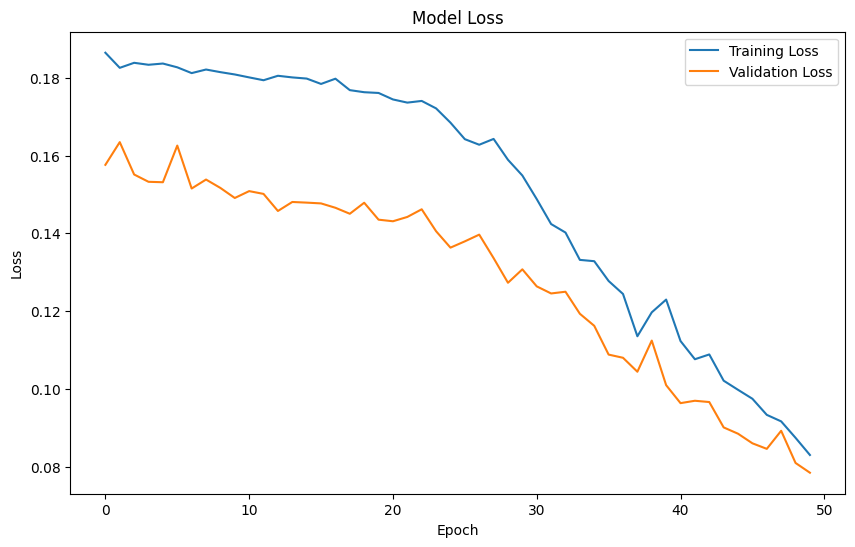

In [13]:
"""Plot training and validation loss."""
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
# Make predictions
predicted_sales = model.predict(X)

# Inverse transform to get actual sales values
predicted_sales = scaler.inverse_transform(predicted_sales.reshape(-1, 1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


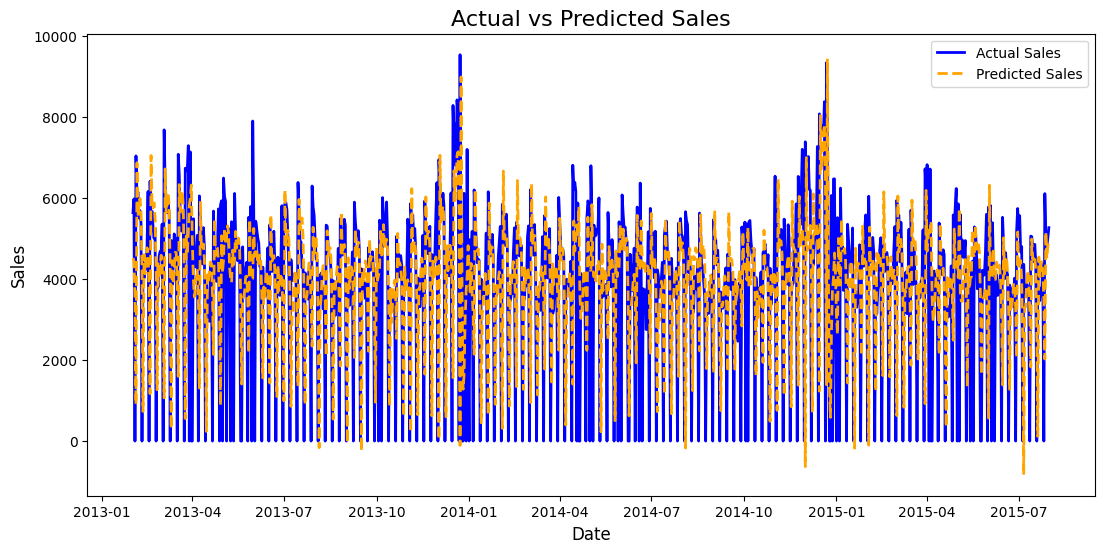

In [15]:
# Plot the the actual vs predicted results
plt.figure(figsize=(13, 6))
plt.plot(store_data.index[n_step+1:], store_data['Sales'][n_step+1:], 
         label='Actual Sales', color='blue', linestyle='-', linewidth=2)

# Plot the predicted sales
plt.plot(store_data.index[n_step+1:], predicted_sales, 
         label='Predicted Sales', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.show()

In [16]:
# Calculate evaluation metrics
mse = mean_squared_error(store_data['Sales'][n_step+1:], predicted_sales)
mae = mean_absolute_error(store_data['Sales'][n_step+1:], predicted_sales)
rmse = np.sqrt(mse)
#r2=r2_score(store_data['Sales'][n_step+1:], predicted_sales)
#msle=mean_squared_log_error(store_data['Sales'][n_step+1:], predicted_sales)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 5021765.5
Mean Absolute Error (MAE): 1539.0716552734375
Mean Squared Error (RMSE): 2240.9296062125645
